In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [ ]:
data = pd.read_csv('./assets/data.csv', index_col = 'Date')
data.shape

(2814, 53)

In [ ]:
data = data.iloc[:, :]
data

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,7ma,14ma,...,S&P500,Japan225,KoreanIndex,NASDQ,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,28.030001,28.240000,27.840000,27.990000,21.152483,48591300,-0.000714,-0.000714,28.146893,28.549826,...,1068.13,9963.99,1570.12,2147.87,154.354910,167.290639,174.546314,180.673782,172.971193,171.012076
2010-02-22,28.840000,28.940001,28.650000,28.730000,21.813244,36707100,-0.001390,-0.001391,28.574012,28.565252,...,1108.01,10400.47,1627.10,2242.03,153.927626,166.244162,172.853763,174.978117,155.958916,149.642177
2010-02-23,28.680000,28.830000,28.090000,28.330000,21.509542,52266200,-0.013923,-0.014021,28.513006,28.533674,...,1094.60,10352.10,1628.90,2213.44,153.499577,165.195810,171.157609,169.279583,139.178566,128.763209
2010-02-24,28.520000,28.790001,28.379999,28.629999,21.737309,43165900,0.010589,0.010534,28.542255,28.546592,...,1105.24,10198.83,1612.83,2235.90,153.070772,164.145658,169.458113,163.585385,122.804635,108.716028
2010-02-25,28.270000,28.650000,28.020000,28.600000,21.714539,48735300,-0.001048,-0.001048,28.556692,28.553749,...,1102.94,10101.96,1587.51,2234.22,152.641219,163.093779,167.755537,157.902711,107.004751,89.817016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,328.299988,333.609985,325.750000,333.200012,326.013550,24831500,0.018057,0.017896,328.801488,330.027902,...,4696.56,28562.21,2984.48,15521.89,156.479535,172.492340,182.945956,208.857466,255.350212,272.899698
2021-12-23,332.750000,336.390015,332.730011,334.690002,327.471405,19617800,0.004472,0.004462,330.273617,330.649516,...,4725.79,28798.37,2998.17,15653.37,156.056212,171.456335,181.275303,203.283823,239.799097,254.311039
2021-12-27,335.459991,342.480011,335.429993,342.450012,335.064087,19947000,0.023186,0.022921,333.317716,332.222915,...,4791.19,28676.46,2999.55,15871.26,155.632079,170.418089,179.599755,197.671538,223.622764,234.509574


In [ ]:
data['y'] = data['Close']

# 检查并替换无穷大或过大的数值
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

x = data.iloc[:, :53].values
y = data.iloc[:, 53].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2239, 53) trainY: (2239,)
testX: (560, 53) testY: (560,)


In [ ]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [ ]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([53, 400, 400, 400, 10], 10)

[1/300] Loss: 740.9141521453857
[2/300] Loss: 669.7072086334229
[3/300] Loss: 600.679349899292
[4/300] Loss: 541.3472290039062
[5/300] Loss: 519.3564071655273
[6/300] Loss: 545.9412651062012
[7/300] Loss: 537.8540439605713
[8/300] Loss: 488.075590133667
[9/300] Loss: 464.7214288711548
[10/300] Loss: 470.383939743042
[11/300] Loss: 479.32365894317627
[12/300] Loss: 479.29707431793213
[13/300] Loss: 468.59741497039795
[14/300] Loss: 449.26999950408936
[15/300] Loss: 427.9108819961548
[16/300] Loss: 414.2422857284546
[17/300] Loss: 413.21878814697266
[18/300] Loss: 416.74344539642334
[19/300] Loss: 409.8013925552368
[20/300] Loss: 391.72105979919434
[21/300] Loss: 376.9231128692627
[22/300] Loss: 372.1916790008545
[23/300] Loss: 373.32146644592285
[24/300] Loss: 374.65792083740234
[25/300] Loss: 373.06050395965576
[26/300] Loss: 367.28653717041016
[27/300] Loss: 357.146183013916
[28/300] Loss: 342.4710054397583
[29/300] Loss: 325.01966381073
[30/300] Loss: 308.2523145675659
[31/300] Loss:

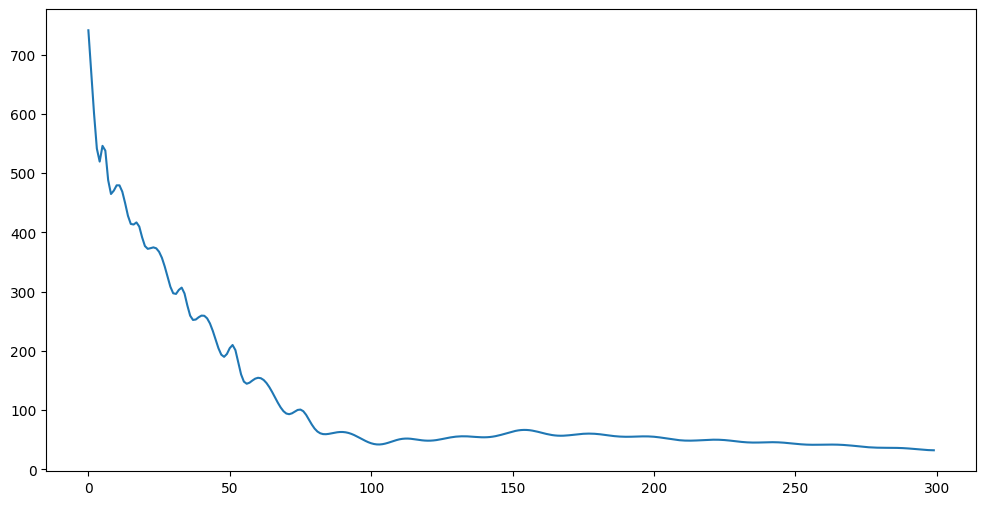

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [ ]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))


In [ ]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [ ]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [ ]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2236, 3, 63]) train_y: torch.Size([2236, 1]) train_y_gan: torch.Size([2236, 4, 1])
test_x: torch.Size([557, 3, 63]) test_y: torch.Size([557, 1]) test_y_gan: torch.Size([557, 4, 1])


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(63).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 24.95342206954956 LossG:12.476142227649689
[2/165] LossD: 24.95315432548523 LossG:12.478484392166138
[3/165] LossD: 24.953546404838562 LossG:12.476724982261658
[4/165] LossD: 24.953396558761597 LossG:12.47698199748993
[5/165] LossD: 24.953272461891174 LossG:12.47762656211853
[6/165] LossD: 24.953357577323914 LossG:12.477039515972137
[7/165] LossD: 24.953318238258362 LossG:12.476557970046997
[8/165] LossD: 24.953234672546387 LossG:12.477015435695648
[9/165] LossD: 24.953269124031067 LossG:12.477537512779236
[10/165] LossD: 24.953224062919617 LossG:12.47706413269043
[11/165] LossD: 24.95321774482727 LossG:12.478139460086823
[12/165] LossD: 24.953169226646423 LossG:12.477322220802307
[13/165] LossD: 24.95317780971527 LossG:12.477162182331085
[14/165] LossD: 24.95316231250763 LossG:12.477814018726349
[15/165] LossD: 24.953146934509277 LossG:12.47807514667511
[16/165] LossD: 24.95300590991974 LossG:12.477788984775543
[17/165] LossD: 24.953078150749207 LossG:12.477903127670288

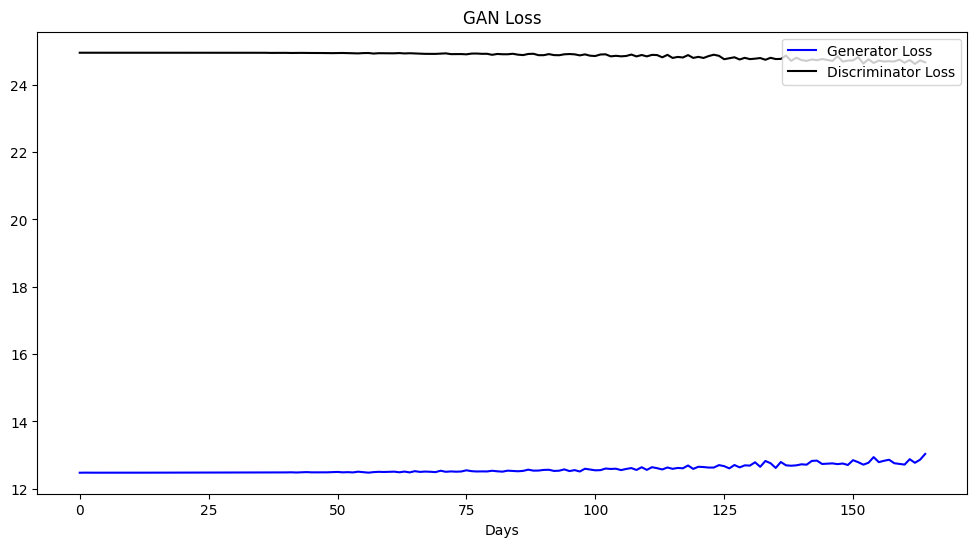

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:3.6855068179575277


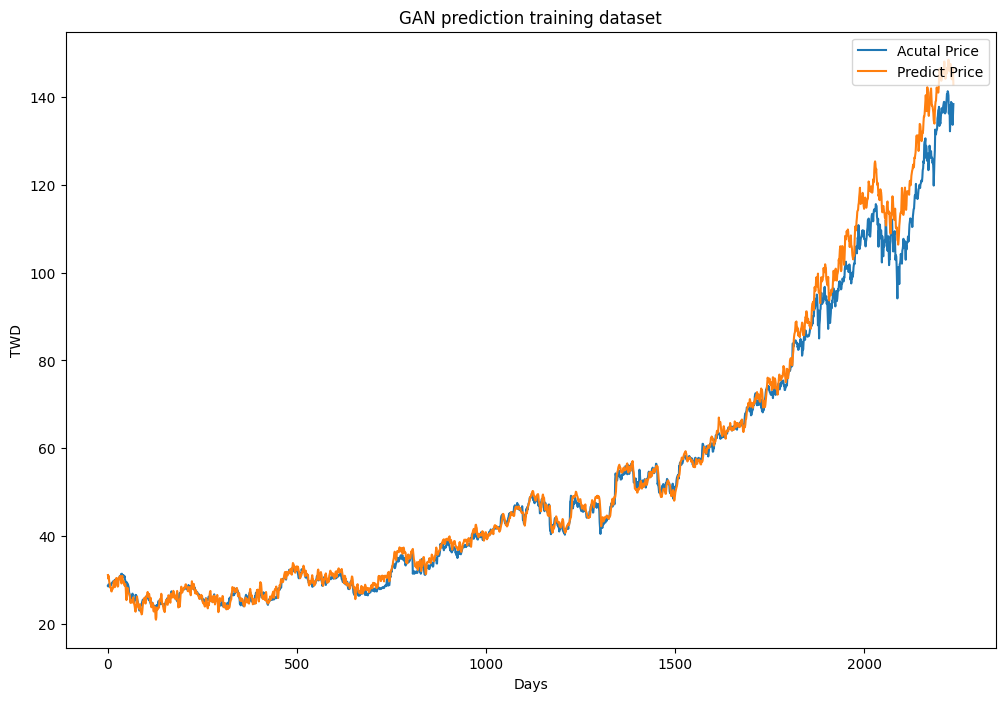

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true,  label = 'Acutal Price')
plt.plot(y_train_pred,  label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:64.8061037355768


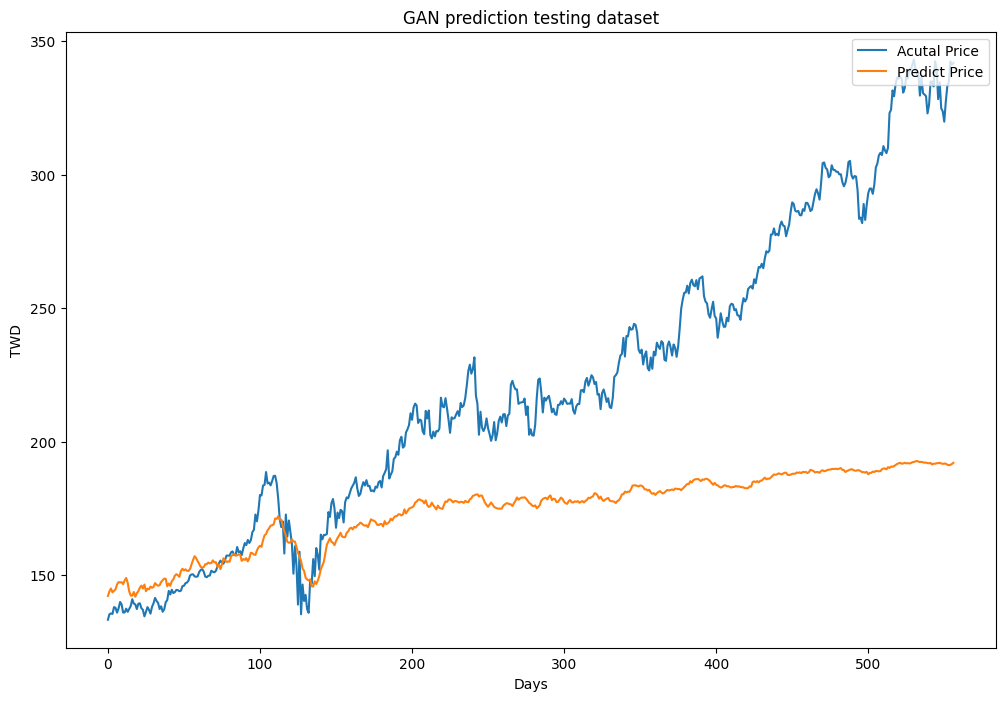

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true,  label = 'Acutal Price')
plt.plot(y_test_pred,  label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')